# Recommender Systems in Python 101

This notebook is a practical introduction to the main [Recommender System](https://en.wikipedia.org/wiki/Recommender_system) (RecSys) techniques. The objective of a RecSys is to recommend relevant items for users, based on their preference. Preference and relevance are subjective, and they are generally inferred by items users have consumed previously.  
The main families of methods for RecSys are:  
- **Collaborative Filtering**: This method makes automatic predictions (filtering) about the interests of a user by collecting preferences or taste information from many users (collaborating). The underlying assumption of the collaborative filtering approach is that if a person A has the same opinion as a person B on a set of items, A is more likely to have B's opinion for a given item than that of a randomly chosen person.   
- **Content-Based Filtering**: This method uses only information about the description and attributes of the items users has previously consumed to model user's preferences. In other words, these algorithms try to recommend items that are similar to those that a user liked in the past (or is examining in the present). In particular, various candidate items are compared with items previously rated by the user and the best-matching items are recommended.  
- **Hybrid methods**:  Recent research has demonstrated that a hybrid approach, combining collaborative filtering and content-based filtering could be more effective than pure approaches in some cases. These methods can also be used to overcome some of the common problems in recommender systems such as cold start and the sparsity problem.

In this notebook, we use a dataset we've shared on Kaggle Datasets: [Articles Sharing and Reading from CI&T Deskdrop](https://www.kaggle.com/gspmoreira/articles-sharing-reading-from-cit-deskdrop).  
We will demonstrate how to implement **Collaborative Filtering**, **Content-Based Filtering** and **Hybrid methods** in Python, for the task of providing personalized recommendations to the users.

In [1]:
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Loading data: CI&T Deskdrop dataset

In this section, we load the [Deskdrop dataset](https://www.kaggle.com/gspmoreira/articles-sharing-reading-from-cit-deskdrop), which contains a real sample of 12 months logs (Mar. 2016 - Feb. 2017) from CI&T's Internal Communication platform (DeskDrop). It contains about 73k logged users interactions on more than 3k public articles shared in the platform.
It is composed of two CSV files:  
- **shared_articles.csv**
- **users_interactions.csv**

Take a look in this kernels for a better picture of the dataset: 
- Deskdrop datasets EDA 
- DeskDrop Articles Topic Modeling

## shared_articles.csv

Contains information about the articles shared in the platform. Each article has its sharing date (timestamp), the original url, title, content in plain text, the article' lang (Portuguese: pt or English: en) and information about the user who shared the article (author).

There are two possible event types at a given timestamp: 
- CONTENT SHARED: The article was shared in the platform and is available for users. 
- CONTENT REMOVED: The article was removed from the platform and not available for further recommendation.

For the sake of simplicity, we only consider here the "CONTENT SHARED" event type, assuming (naively) that all articles were available during the whole one year period. For a more precise evaluation (and higher accuracy), only articles that were available at a given time should be recommended, but we let this exercice for you.

In [2]:
articles_df = pd.read_csv('shared_articles.csv')
articles_df = articles_df[articles_df['eventType'] == 'CONTENT SHARED']
articles_df.head(5)

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en
5,1459194522,CONTENT SHARED,-2826566343807132236,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.coindesk.com/ieee-blockchain-oxford...,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,en


## users_interactions.csv

Contains logs of user interactions on shared articles. It can be joined to **articles_shared.csv** by **contentId** column.

The eventType values are:  
- **VIEW**: The user has opened the article. 
- **LIKE**: The user has liked the article. 
- **COMMENT CREATED**: The user created a comment in the article. 
- **FOLLOW**: The user chose to be notified on any new comment in the article. 
- **BOOKMARK**: The user has bookmarked the article for easy return in the future.

In [3]:
interactions_df = pd.read_csv('users_interactions.csv')
interactions_df.head(10)

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN
5,1465413742,VIEW,310515487419366995,-8763398617720485024,1395789369402380392,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,MG,BR
6,1465415950,VIEW,-8864073373672512525,3609194402293569455,1143207167886864524,NaN,NaN,NaN
7,1465415066,VIEW,-1492913151930215984,4254153380739593270,8743229464706506141,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR
8,1465413762,VIEW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
9,1465413771,VIEW,3064370296170038610,3609194402293569455,1143207167886864524,NaN,NaN,NaN


## Data munging

As there are different interactions types, we associate them with a weight or strength, assuming that, for example, a comment in an article indicates a higher interest of the user on the item than a like, or than a simple view.

In [4]:
event_type_strength = {
   'VIEW': 1.0,
   'LIKE': 2.0, 
   'BOOKMARK': 3.0, 
   'FOLLOW': 4.0,
   'COMMENT CREATED': 5.0,  
}

interactions_df['eventStrength'] = interactions_df['eventType'].apply(lambda x: event_type_strength[x])

Recommender systems have a problem known as ***user cold-start***, in which is hard do provide personalized recommendations for users with none or a very few number of consumed items, due to the lack of information to model their preferences.  
For this reason, we are keeping in the dataset only users with at leas 5 interactions.

In [5]:
users_interactions_count_df = interactions_df.groupby(['personId', 'contentId']).size().groupby('personId').size()
print('# users: %d' % len(users_interactions_count_df))
users_with_enough_interactions_df = users_interactions_count_df[users_interactions_count_df >= 5].reset_index()[['personId']]
print('# users with at least 5 interactions: %d' % len(users_with_enough_interactions_df))

# users: 1895
# users with at least 5 interactions: 1140


In [6]:
print('# of interactions: %d' % len(interactions_df))
interactions_from_selected_users_df = interactions_df.merge(users_with_enough_interactions_df, 
               how = 'right',
               left_on = 'personId',
               right_on = 'personId')
print('# of interactions from users with at least 5 interactions: %d' % len(interactions_from_selected_users_df))

# of interactions: 72312
# of interactions from users with at least 5 interactions: 69868


In Deskdrop, users are allowed to view an article many times, and interact with them in different ways (eg. like or comment). Thus, to model the user interest on a given article, we aggregate all the interactions the user has performed in an item by a weighted sum of interaction type strength and apply a log transformation to smooth the distribution.

In [7]:
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_full_df = interactions_from_selected_users_df \
                    .groupby(['personId', 'contentId'])['eventStrength'].sum() \
                    .apply(smooth_user_preference).reset_index()
print('# of unique user/item interactions: %d' % len(interactions_full_df))
interactions_full_df.head(10)

# of unique user/item interactions: 39106


,personId,contentId,eventStrength
0,-9223121837663643404,-8949113594875411859,1.000000
1,-9223121837663643404,-8377626164558006982,1.000000
2,-9223121837663643404,-8208801367848627943,1.000000
3,-9223121837663643404,-8187220755213888616,1.000000
4,-9223121837663643404,-7423191370472335463,3.169925
5,-9223121837663643404,-7331393944609614247,1.000000
6,-9223121837663643404,-6872546942144599345,1.000000
7,-9223121837663643404,-6728844082024523434,1.000000
8,-9223121837663643404,-6590819806697898649,1.000000
9,-9223121837663643404,-6558712014192834002,1.584963


# Evaluation

Evaluation is important for machine learning projects, because it allows to compare objectivelly different algorithms and hyperparameter choices for models.  
One key aspect of evaluation is to ensure that the trained model generalizes for data it was not trained on, using **Cross-validation** techniques. We are using here a simple cross-validation approach named **holdout**, in which a random data sample (20% in this case) are kept aside in the training process, and exclusively used for evaluation. All evaluation metrics reported here are computed using the **test set**.

Ps. A more robust evaluation approach could be to split train and test sets by a reference date, where the train set is composed by all interactions before that date, and the test set are interactions after that date. For the sake of simplicity, we chose the first random approach for this notebook, but you may want to try the second approach to better simulate how the recsys would perform in production predicting "future" users interactions.

In [8]:
interactions_train_df, interactions_test_df = train_test_split(interactions_full_df,
                                   stratify=interactions_full_df['personId'], 
                                   test_size=0.20,
                                   random_state=0)

print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

# interactions on Train set: 31284
# interactions on Test set: 7822


In Recommender Systems, there are a set metrics commonly used for evaluation. We chose to work with **Top-K accuracy metrics**, which evaluates the accuracy of the top recommendations provided to a user, comparing to the items the user has actually interacted in test set.  
This evaluation method works as follows:

* For each user
    * For each item the user has interacted in test set
        * Sample 100 other items the user has never interacted.   
        Ps. Here we naively assume those non interacted items are not relevant to the user, which might not be true, as the user may simply not be aware of those not interacted items. But let's keep this assumption.
        * Ask the recommender model to produce a ranked list of recommended items, from a set composed one interacted item and the 100 non-interacted ("non-relevant!) items
        * Compute the Top-K accuracy metrics for this user and interacted item from the recommendations ranked list
* Aggregate the global Top-K accuracy metrics

The Top-K accuracy metric choosen was **Recall@K** which evaluates whether the interacted item is among the top K items (hit) in the ranked list of 101 recommendations for a user.  
Ps. Other popular ranking metrics are **NDCG@K** and **MAP@K**, whose score calculation takes into account the position of the relevant item in the ranked list (max. value if relevant item is in the first position). You can find a reference to implement this metrics in this [post](http://fastml.com/evaluating-recommender-systems/).

In [9]:
#Indexing by personId to speed up the searches during evaluation
interactions_full_indexed_df = interactions_full_df.set_index('personId')
interactions_train_indexed_df = interactions_train_df.set_index('personId')
interactions_test_indexed_df = interactions_test_df.set_index('personId')

In [10]:
def get_items_interacted(person_id, interactions_df):
    # Get the user's data and merge in the movie information.
    interacted_items = interactions_df.loc[person_id]['contentId']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [11]:
#Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:


    def get_not_interacted_items_sample(self, person_id, sample_size, seed=42):
        interacted_items = get_items_interacted(person_id, interactions_full_indexed_df)
        all_items = set(articles_df['contentId'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index

    def evaluate_model_for_user(self, model, person_id):
        #Getting the items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[person_id]
        if type(interacted_values_testset['contentId']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['contentId'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['contentId'])])  
        interacted_items_count_testset = len(person_interacted_items_testset) 

        #Getting a ranked recommendation list from a model for a given user
        person_recs_df = model.recommend_items(person_id, 
                                               items_to_ignore=get_items_interacted(person_id, 
                                                                                    interactions_train_indexed_df), 
                                               topn=10000000000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        #For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            #Getting a random sample (100) items the user has not interacted 
            #(to represent items that are assumed to be no relevant to the user)
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id, 
                                                                          sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, 
                                                                          seed=item_id%(2**32))

            #Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['contentId'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['contentId'].values
            #Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items, 
        #when mixed with a set of non-relevant items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    def evaluate_model(self, model):
        #print('Running evaluation for users')
        people_metrics = []
        for idx, person_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):
            #if idx % 100 == 0 and idx > 0:
            #    print('%d users processed' % idx)
            person_metrics = self.evaluate_model_for_user(model, person_id)  
            person_metrics['_person_id'] = person_id
            people_metrics.append(person_metrics)
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator()    

# Popularity model

A common (and usually hard-to-beat) baseline approach is the Popularity model. This model is not actually personalized - it simply recommends to a user the most popular items that the user has not previously consumed. As the popularity accounts for the "wisdom of the crowds", it usually provides good recommendations, generally interesting for most people.   
Ps. The main objective of a recommender system is to leverage the long-tail items to the users with very specific interests, which goes far beyond this simple technique.

In [12]:
#Computes the most popular items
item_popularity_df = interactions_full_df.groupby('contentId')['eventStrength'].sum().sort_values(ascending=False).reset_index()
item_popularity_df.head(10)

,contentId,eventStrength
0,-4029704725707465084,310.791362
1,-6783772548752091658,237.145410
2,-133139342397538859,229.089057
3,-8208801367848627943,199.660338
4,-6843047699859121724,196.174998
5,8224860111193157980,191.584205
6,-2358756719610361882,186.528260
7,2581138407738454418,182.495414
8,7507067965574797372,181.070143
9,1469580151036142903,172.066596


In [13]:
class PopularityRecommender:
    
    MODEL_NAME = 'Popularity'
    
    def __init__(self, popularity_df, items_df=None):
        self.popularity_df = popularity_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Recommend the more popular items that the user hasn't seen yet.
        recommendations_df = self.popularity_df[~self.popularity_df['contentId'].isin(items_to_ignore)] \
                               .sort_values('eventStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['eventStrength', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df
    
popularity_model = PopularityRecommender(item_popularity_df, articles_df)

Here we perform the evaluation of the Popularity model, according to the method described above.  
It might be surprising to you that usually Popularity models could perform so well!

In [14]:
print('Evaluating Popularity recommendation model...')
pop_global_metrics, pop_detailed_results_df = model_evaluator.evaluate_model(popularity_model)
print('\nGlobal metrics:\n%s' % pop_global_metrics)
pop_detailed_results_df.head(10)

Evaluating Popularity recommendation model...
1139 users processed

Global metrics:
{'modelName': 'Popularity', 'recall@5': 0.253899258501662, 'recall@10': 0.3781641523906929}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
97,24,53,192,0.125000,0.276042,3609194402293569455
77,10,24,134,0.074627,0.179104,-2626634673110551643
10,11,28,130,0.084615,0.215385,-1032019229384696495
14,3,8,117,0.025641,0.068376,-1443636648652872475
62,18,29,88,0.204545,0.329545,-2979881261169775358
44,18,23,80,0.225000,0.287500,-3596626804281480007
56,15,22,73,0.205479,0.301370,1116121227607581999
152,15,19,69,0.217391,0.275362,-9016528795238256703
11,21,27,69,0.304348,0.391304,692689608292948411
78,15,26,68,0.220588,0.382353,3636910968448833585


# Content-Based Filtering model

Content-based filtering approaches leverage description or attributes from items the user has interacted to recommend similar items. It depends only on the user previous choices, making this method robust to avoid the *cold-start* problem.
For textual items, like articles, news and books, it is simple to use the raw text to build item profiles and user profiles.  
Here we are using a very popular technique in information retrieval (search engines) named [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf). This technique converts unstructured text into a vector structure, where each word is represented by a position in the vector, and the value measures how relevant a given word is for an article. As all items will be represented in the same [Vector Space Model](https://en.wikipedia.org/wiki/Vector_space_model), it is to compute similarity between articles.  
See this [presentation](https://www.slideshare.net/gabrielspmoreira/discovering-users-topics-of-interest-in-recommender-systems-tdc-sp-2016) (from slide 30) for more information on TF-IDF and Cosine similarity.

In [15]:
#Ignoring stopwords (words with no semantics) from English and Portuguese (as we have a corpus with mixed languages)
stopwords_list = stopwords.words('english') + stopwords.words('portuguese')

#Trains a model whose vectors size is 5000, composed by the main unigrams and bigrams found in the corpus, ignoring stopwords
vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     min_df=0.003,
                     max_df=0.5,
                     max_features=5000,
                     stop_words=stopwords_list)

item_ids = articles_df['contentId'].tolist()
tfidf_matrix = vectorizer.fit_transform(articles_df['title'] + "" + articles_df['text'])
tfidf_feature_names = vectorizer.get_feature_names()
tfidf_matrix

<3047x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 638928 stored elements in Compressed Sparse Row format>

To model the user profile, we take all the item profiles the user has interacted and average them. The average is weighted by the interaction strength, in other words, the articles the user has interacted the most (eg. liked or commented) will have a higher strength in the final user profile.   

In [16]:
def get_item_profile(item_id):
    idx = item_ids.index(item_id)
    item_profile = tfidf_matrix[idx:idx+1]
    return item_profile

def get_item_profiles(ids):
    item_profiles_list = [get_item_profile(x) for x in ids]
    item_profiles = scipy.sparse.vstack(item_profiles_list)
    return item_profiles

def build_users_profile(person_id, interactions_indexed_df):
    interactions_person_df = interactions_indexed_df.loc[person_id]
    user_item_profiles = get_item_profiles(interactions_person_df['contentId'])
    
    user_item_strengths = np.array(interactions_person_df['eventStrength']).reshape(-1,1)
    #Weighted average of item profiles by the interactions strength
    user_item_strengths_weighted_avg = np.sum(user_item_profiles.multiply(user_item_strengths), axis=0) / np.sum(user_item_strengths)
    user_profile_norm = sklearn.preprocessing.normalize(user_item_strengths_weighted_avg)
    return user_profile_norm

def build_users_profiles(): 
    interactions_indexed_df = interactions_train_df[interactions_train_df['contentId'] \
                                                   .isin(articles_df['contentId'])].set_index('personId')
    user_profiles = {}
    for person_id in interactions_indexed_df.index.unique():
        user_profiles[person_id] = build_users_profile(person_id, interactions_indexed_df)
    return user_profiles

In [17]:
user_profiles = build_users_profiles()
len(user_profiles)

1140

Let's take a look in the profile. It is a [unit vector](https://en.wikipedia.org/wiki/Unit_vector) of 5000 length. The value in each position represents how relevant is a token (unigram or bigram) for me.  
Looking my profile, it appears that the top relevant tokens really represent my professional interests in **machine learning**, **deep learning**, **artificial intelligence** and **google cloud platform**! So we might expect good recommendations here!

In [18]:
myprofile = user_profiles[-1479311724257856983]
print(myprofile.shape)
pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        user_profiles[-1479311724257856983].flatten().tolist()), key=lambda x: -x[1])[:20],
             columns=['token', 'relevance'])

(1, 5000)


,token,relevance
0,learning,0.307827
1,machine learning,0.246683
2,machine,0.240583
3,google,0.174030
4,data,0.158020
5,ai,0.136109
6,graph,0.121212
7,algorithms,0.109066
8,like,0.098575
9,language,0.090690


In [19]:
class ContentBasedRecommender:
    
    MODEL_NAME = 'Content-Based'
    
    def __init__(self, items_df=None):
        self.item_ids = item_ids
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def _get_similar_items_to_user_profile(self, person_id, topn=1000):
        #Computes the cosine similarity between the user profile and all item profiles
        cosine_similarities = cosine_similarity(user_profiles[person_id], tfidf_matrix)
        #Gets the top similar items
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        #Sort the similar items by similarity
        similar_items = sorted([(item_ids[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: -x[1])
        return similar_items
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        similar_items = self._get_similar_items_to_user_profile(user_id)
        #Ignores items the user has already interacted
        similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))
        
        recommendations_df = pd.DataFrame(similar_items_filtered, columns=['contentId', 'recStrength']) \
                                    .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrength', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df
    
content_based_recommender_model = ContentBasedRecommender(articles_df)

The lower performance of the Content-Based model compared to the Popularity model may indicate that users are not that fixed in content very similar to their previous reads.

In [20]:
print('Evaluating Content-Based Filtering model...')
cb_global_metrics, cb_detailed_results_df = model_evaluator.evaluate_model(content_based_recommender_model)
print('\nGlobal metrics:\n%s' % cb_global_metrics)
cb_detailed_results_df.head(10)

Evaluating Content-Based Filtering model...
1139 users processed

Global metrics:
{'modelName': 'Content-Based', 'recall@5': 0.16696497059575557, 'recall@10': 0.2654052671950908}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
97,17,30,192,0.088542,0.156250,3609194402293569455
77,13,22,134,0.097015,0.164179,-2626634673110551643
10,19,39,130,0.146154,0.300000,-1032019229384696495
14,32,49,117,0.273504,0.418803,-1443636648652872475
62,7,15,88,0.079545,0.170455,-2979881261169775358
44,14,25,80,0.175000,0.312500,-3596626804281480007
56,5,11,73,0.068493,0.150685,1116121227607581999
152,10,14,69,0.144928,0.202899,-9016528795238256703
11,9,19,69,0.130435,0.275362,692689608292948411
78,3,12,68,0.044118,0.176471,3636910968448833585


# Collaborative Filtering model

Collaborative Filtering (CF) has two main implementation strategies:  
- **Memory-based**: This approach uses the memory of previous users interactions to compute users similarities based on items they've interacted (user-based approach) or compute items similarities based on the users that have interacted with them (item-based approach).  
A typical example of this approach is User Neighbourhood-based CF, in which the top-N similar users (usually computed using Pearson correlation) for a user are selected and used to recommend items those similar users liked, but the current user have not interacted yet. This approach is very simple to implement, but usually do not scale well for many users. 
- **Model-based**: This approach, models are developed using different machine learning algorithms to recommend items to users. There are many model-based CF algorithms, like neural networks, bayesian networks, clustering models, and latent factor models such as Singular Value Decomposition (SVD) and, probabilistic latent semantic analysis.

## Matrix Factorization

Latent factor models compress user-item matrix into a low-dimensional representation in terms of latent factors. One advantage of using this approach is that instead of having a high dimensional matrix containing abundant number of missing values we will be dealing with a much smaller matrix in lower-dimensional space.  
A reduced presentation could be utilized for either user-based or item-based neighborhood algorithms that are presented in the previous section. There are several advantages with this paradigm. It handles the sparsity of the original matrix better than memory based ones. Also comparing similarity on the resulting matrix is much more scalable especially in dealing with large sparse datasets.  

Here we a use popular latent factor model named [Singular Value Decomposition (SVD)](https://en.wikipedia.org/wiki/Singular_value_decomposition). There are other matrix factorization frameworks more specific to CF you might try, like [surprise](https://github.com/NicolasHug/Surprise), [mrec](https://github.com/Mendeley/mrec) or [python-recsys](https://github.com/ocelma/python-recsys). We chose a [SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.svds.html) implemenation of SVD because it is available on Kaggle kernels. 
P.s. See an example of SVD on a movies dataset in this [blog post](https://beckernick.github.io/matrix-factorization-recommender/).   

An important decision is the number of factors to factor the user-item matrix. The higher the number of factors, the more precise is the factorization in the original matrix reconstructions. Therefore, if the model is allowed to  memorize too much details of the original matrix, it may not generalize well for data it was not trained on. Reducing the number of factors increases the model generalization.

In [21]:
#Creating a sparse pivot table with users in rows and items in columns
users_items_pivot_matrix_df = interactions_train_df.pivot(index='personId', 
                                                          columns='contentId', 
                                                          values='eventStrength').fillna(0)

users_items_pivot_matrix_df.head(10)

contentId,-9222795471790223670,-9216926795620865886,-9194572880052200111,-9192549002213406534,-9190737901804729417,-9189659052158407108,-9184137057748005562,-9176143510534135851,-9172673334835262304,-9171475473795142532,...,9191014301634017491,9207286802575546269,9208127165664287660,9209629151177723638,9209886322932807692,9213260650272029784,9215261273565326920,9217155070834564627,9220445660318725468,9222265156747237864
personId,,,,,,,,,,,,,,,,,,,,,
-9223121837663643404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9212075797126931087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9207251133131336884,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9199575329909162940,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9196668942822132778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9188188261933657343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9172914609055320039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9156344805277471150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9120685872592674274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
users_items_pivot_matrix = np.array(users_items_pivot_matrix_df)
users_items_pivot_matrix[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 2., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [23]:
users_ids = list(users_items_pivot_matrix_df.index)
users_ids[:10]

[-9223121837663643404,
 -9212075797126931087,
 -9207251133131336884,
 -9199575329909162940,
 -9196668942822132778,
 -9188188261933657343,
 -9172914609055320039,
 -9156344805277471150,
 -9120685872592674274,
 -9109785559521267180]

In [24]:
users_items_pivot_sparse_matrix = csr_matrix(users_items_pivot_matrix)
users_items_pivot_sparse_matrix

<1140x2921 sparse matrix of type '<class 'numpy.float64'>'
	with 31284 stored elements in Compressed Sparse Row format>

In [25]:
#The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 15
#Performs matrix factorization of the original user item matrix
#U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)
U, sigma, Vt = svds(users_items_pivot_sparse_matrix, k = NUMBER_OF_FACTORS_MF)

In [26]:
U.shape

(1140, 15)

In [27]:
Vt.shape

(15, 2921)

In [28]:
sigma = np.diag(sigma)
sigma.shape

(15, 15)

After the factorization, we try to to reconstruct the original matrix by multiplying its factors. The resulting matrix is not sparse any more. It was generated predictions for items the user have not yet interaction, which we will exploit for recommendations.

In [29]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings

array([[ 5.61414549e-02,  6.66554459e-03,  3.30189410e-02, ...,
         9.13034182e-03, -2.26551755e-02, -1.92635862e-03],
       [ 1.81537776e-03,  1.30587202e-04, -1.20660039e-03, ...,
        -5.54728699e-03,  5.33004665e-05, -1.02808252e-03],
       [-1.25194982e-02,  8.14732804e-03, -3.10626071e-03, ...,
         1.16741378e-02, -5.82821322e-03,  7.44975154e-03],
       ...,
       [-1.75110368e-02,  1.86387368e-03, -7.75051706e-03, ...,
        -1.34277537e-02, -5.59122422e-03,  3.41612403e-04],
       [ 2.02224847e-02,  8.23897825e-03,  7.15516753e-03, ...,
         2.92240583e-03,  1.06816050e-02, -3.47502912e-03],
       [-2.54163911e-02,  4.75575632e-03,  6.84880113e-02, ...,
        -3.33659128e-02,  2.28069197e-02,  9.81131945e-03]])

In [30]:
all_user_predicted_ratings_norm = (all_user_predicted_ratings - all_user_predicted_ratings.min()) / (all_user_predicted_ratings.max() - all_user_predicted_ratings.min())

In [31]:
#Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings_norm, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
cf_preds_df.head(10)

,-9223121837663643404,-9212075797126931087,-9207251133131336884,-9199575329909162940,-9196668942822132778,-9188188261933657343,-9172914609055320039,-9156344805277471150,-9120685872592674274,-9109785559521267180,...,9105269044962898535,9109075639526981934,9135582630122950040,9137372837662939523,9148269800512008413,9165571805999894845,9187866633451383747,9191849144618614467,9199170757466086545,9210530975708218054
contentId,,,,,,,,,,,,,,,,,,,,,
-9222795471790223670,0.156884,0.150913,0.149337,0.154307,0.149334,0.150149,0.153065,0.154902,0.149776,0.151717,...,0.154677,0.149689,0.149940,0.151202,0.146951,0.149678,0.150809,0.148789,0.152936,0.147920
-9216926795620865886,0.151446,0.150728,0.151609,0.150714,0.150883,0.150726,0.150955,0.150874,0.150527,0.151097,...,0.150970,0.153844,0.150695,0.150662,0.152638,0.151019,0.150953,0.150918,0.151619,0.151236
-9194572880052200111,0.154342,0.150581,0.150372,0.150382,0.152770,0.150918,0.151757,0.151565,0.149775,0.149722,...,0.150365,0.162014,0.151234,0.151160,0.157801,0.153022,0.151240,0.149861,0.151500,0.158241
-9192549002213406534,0.155123,0.151680,0.150306,0.149296,0.153337,0.151710,0.151317,0.157523,0.153112,0.148059,...,0.150585,0.178662,0.150984,0.150251,0.160731,0.154411,0.151822,0.149607,0.153300,0.161674
-9190737901804729417,0.152975,0.150431,0.152583,0.151264,0.150465,0.150939,0.151226,0.150149,0.149208,0.154202,...,0.151245,0.154052,0.150671,0.150427,0.148476,0.150617,0.150726,0.150845,0.151630,0.150974
-9189659052158407108,0.152499,0.151555,0.149864,0.150164,0.152008,0.150803,0.150824,0.151041,0.153523,0.150814,...,0.153096,0.154078,0.150959,0.151047,0.160657,0.151835,0.151829,0.152712,0.151386,0.159391
-9184137057748005562,0.150968,0.150717,0.151098,0.150742,0.150680,0.150738,0.150804,0.150704,0.150746,0.151145,...,0.150849,0.151652,0.150653,0.150609,0.150713,0.150725,0.150762,0.150900,0.151088,0.150707
-9176143510534135851,0.156617,0.150268,0.150076,0.152724,0.150040,0.150442,0.152244,0.150645,0.158406,0.157754,...,0.152549,0.155920,0.149461,0.149825,0.148209,0.150063,0.150977,0.156765,0.153267,0.153019
-9172673334835262304,0.150899,0.150878,0.150936,0.150639,0.150787,0.150745,0.150777,0.151125,0.150350,0.150794,...,0.151071,0.151716,0.150673,0.150613,0.151102,0.150849,0.150943,0.150455,0.151270,0.150656


In [32]:
len(cf_preds_df.columns)

1140

In [33]:
class CFRecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={user_id: 'recStrength'})

        # Recommend the highest predicted rating movies that the user hasn't seen yet.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['contentId'].isin(items_to_ignore)] \
                               .sort_values('recStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrength', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df
    
cf_recommender_model = CFRecommender(cf_preds_df, articles_df)

> Evaluating the Collaborative Filtering model (SVD matrix factorization), we observe that we got **Recall@5** and **Recall@10** values, much higher than Popularity model and Content-Based model.

In [34]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model)
print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
1139 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': 0.3352083866018921, 'recall@10': 0.4648427512145231}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
97,25,47,192,0.130208,0.244792,3609194402293569455
77,26,43,134,0.194030,0.320896,-2626634673110551643
10,24,33,130,0.184615,0.253846,-1032019229384696495
14,30,46,117,0.256410,0.393162,-1443636648652872475
62,23,39,88,0.261364,0.443182,-2979881261169775358
44,18,22,80,0.225000,0.275000,-3596626804281480007
56,23,32,73,0.315068,0.438356,1116121227607581999
152,19,28,69,0.275362,0.405797,-9016528795238256703
11,15,25,69,0.217391,0.362319,692689608292948411
78,12,23,68,0.176471,0.338235,3636910968448833585


## Hybrid Recommender

What if we combine Collaborative Filtering and Content-Based Filtering approaches?    
Would that provide us with more accurate recommendations?    
In fact, hybrid methods have performed better than individual approaches in many studies and have being extensively used by researchers and practioners.  
Let's build a simple hybridization method, as an ensemble that takes the weighted average of the normalized CF scores with the Content-Based scores, and ranking by resulting score. In this case, as the CF model is much more accurate than the CB model, the weights for the CF and CB models are 100.0 and 1.0, respectivelly.

In [35]:
class HybridRecommender:
    
    MODEL_NAME = 'Hybrid'
    
    def __init__(self, cb_rec_model, cf_rec_model, items_df, cb_ensemble_weight=1.0, cf_ensemble_weight=1.0):
        self.cb_rec_model = cb_rec_model
        self.cf_rec_model = cf_rec_model
        self.cb_ensemble_weight = cb_ensemble_weight
        self.cf_ensemble_weight = cf_ensemble_weight
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        #Getting the top-1000 Content-based filtering recommendations
        cb_recs_df = self.cb_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose,
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCB'})
        
        #Getting the top-1000 Collaborative filtering recommendations
        cf_recs_df = self.cf_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose, 
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCF'})
        
        #Combining the results by contentId
        recs_df = cb_recs_df.merge(cf_recs_df,
                                   how = 'outer', 
                                   left_on = 'contentId', 
                                   right_on = 'contentId').fillna(0.0)
        
        #Computing a hybrid recommendation score based on CF and CB scores
        #recs_df['recStrengthHybrid'] = recs_df['recStrengthCB'] * recs_df['recStrengthCF'] 
        recs_df['recStrengthHybrid'] = (recs_df['recStrengthCB'] * self.cb_ensemble_weight) \
                                     + (recs_df['recStrengthCF'] * self.cf_ensemble_weight)
        
        #Sorting recommendations by hybrid score
        recommendations_df = recs_df.sort_values('recStrengthHybrid', ascending=False).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrengthHybrid', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df

# test combinations of weights content_based_recommender_model and cf_recommender_model
hybrid_recommender_model = HybridRecommender(content_based_recommender_model, cf_recommender_model, articles_df,
                                             cb_ensemble_weight=1.0, cf_ensemble_weight=50.0)

**We have a new champion!**  
Our simple hybrid approach surpasses Content-Based filtering with its combination with Collaborative Filtering.

In [36]:
print('Evaluating Hybrid model...')
hybrid_global_metrics, hybrid_detailed_results_df = model_evaluator.evaluate_model(hybrid_recommender_model)
print('\nGlobal metrics:\n%s' % hybrid_global_metrics)
hybrid_detailed_results_df.head(10)

Evaluating Hybrid model...
1139 users processed

Global metrics:
{'modelName': 'Hybrid', 'recall@5': 0.3445410380976732, 'recall@10': 0.4767322935310662}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
97,28,50,192,0.145833,0.260417,3609194402293569455
77,27,41,134,0.201493,0.305970,-2626634673110551643
10,27,40,130,0.207692,0.307692,-1032019229384696495
14,35,47,117,0.299145,0.401709,-1443636648652872475
62,23,39,88,0.261364,0.443182,-2979881261169775358
44,18,23,80,0.225000,0.287500,-3596626804281480007
56,21,32,73,0.287671,0.438356,1116121227607581999
152,19,28,69,0.275362,0.405797,-9016528795238256703
11,16,24,69,0.231884,0.347826,692689608292948411
78,13,21,68,0.191176,0.308824,3636910968448833585


## Comparing the methods

In [37]:
global_metrics_df = pd.DataFrame([cb_global_metrics, pop_global_metrics, cf_global_metrics, hybrid_global_metrics]) \
                        .set_index('modelName')
global_metrics_df

,recall@5,recall@10
modelName,,
Content-Based,0.166965,0.265405
Popularity,0.253899,0.378164
Collaborative Filtering,0.335208,0.464843
Hybrid,0.344541,0.476732


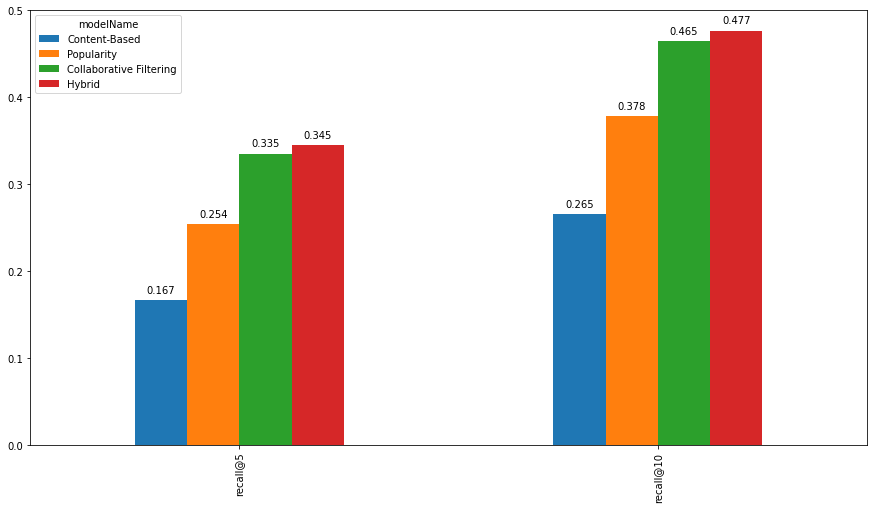

In [38]:
%matplotlib inline
ax = global_metrics_df.transpose().plot(kind='bar', figsize=(15,8))
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Testing

Let's test the best model (Hybrid) for a user.

In [39]:
def inspect_interactions(person_id, test_set=True):
    if test_set:
        interactions_df = interactions_test_indexed_df
    else:
        interactions_df = interactions_train_indexed_df
    return interactions_df.loc[person_id].merge(articles_df, how = 'left', 
                                                      left_on = 'contentId', 
                                                      right_on = 'contentId') \
                          .sort_values('eventStrength', ascending = False)[['eventStrength', 
                                                                          'contentId',
                                                                          'title', 'url', 'lang']]

Here we see some articles that user interacted in Deskdrop from train set. It can be easily observed that among my his/her interests are **machine learning**, **deep learning**, **artificial intelligence**, and **google cloud platform**.

In [40]:
inspect_interactions(-1479311724257856983, test_set=False).head(20)

,eventStrength,contentId,title,url,lang
59,4.459432,7342707578347442862,"At eBay, Machine Learning is Driving Innovativ...",https://www.ebayinc.com/stories/news/at-ebay-m...,en
58,4.169925,2589533162305407436,6 reasons why I like KeystoneML,http://radar.oreilly.com/2015/07/6-reasons-why...,en
3,4.169925,621816023396605502,AI Is Here to Help You Write Emails People Wil...,http://www.wired.com/2016/08/boomerang-using-a...,en
86,4.087463,-4460374799273064357,"Deep Learning for Chatbots, Part 1 - Introduction",http://www.wildml.com/2016/04/deep-learning-fo...,en
22,4.000000,-7959318068735027467,Auto-scaling scikit-learn with Spark,https://databricks.com/blog/2016/02/08/auto-sc...,en
56,4.000000,5258604889412591249,Machine Learning Is No Longer Just for Experts,https://hbr.org/2016/10/machine-learning-is-no...,en
44,3.807355,-6467708104873171151,5 reasons your employees aren't sharing their ...,http://justcuriousblog.com/2016/04/5-reasons-y...,en
114,3.700440,-5658245291907121574,Machine Learning and the VP Debate,https://medium.com/@srobtweets/machine-learnin...,en
104,3.700440,-8377626164558006982,Bad Writing Is Destroying Your Company's Produ...,https://hbr.org/2016/09/bad-writing-is-destroy...,en
64,3.700440,-532999578436827210,IBM Seeks to Simplify Graph with New Titan Ser...,https://www.datanami.com/2016/07/27/ibm-seeks-...,en


**Do you think the recommendations matches his/her interests?**

In [41]:
hybrid_recommender_model.recommend_items(-1479311724257856983, topn=20, verbose=True)

,recStrengthHybrid,contentId,title,url,lang
0,14.525430,-6467708104873171151,5 reasons your employees aren't sharing their ...,http://justcuriousblog.com/2016/04/5-reasons-y...,en
1,13.700747,4118743389464105405,Why Google App Engine rocks: A Google engineer...,https://cloudplatform.googleblog.com/2016/04/w...,en
2,13.664940,-7126520323752764957,"How Google is Remaking Itself as a ""Machine Le...",https://backchannel.com/how-google-is-remaking...,en
3,13.453144,-8190931845319543363,Machine Learning Is At The Very Peak Of Its Hy...,https://arc.applause.com/2016/08/17/gartner-hy...,en
4,13.400040,2589533162305407436,6 reasons why I like KeystoneML,http://radar.oreilly.com/2015/07/6-reasons-why...,en
5,12.699453,-8085935119790093311,Graph Capabilities with the Elastic Stack,https://www.elastic.co/webinars/sneak-peek-of-...,en
6,12.687447,-8771338872124599367,Funcionários do mês no CoolHow: os Slackbots -...,https://medium.com/coolhow-creative-lab/funcio...,pt
7,12.684437,-6727357771678896471,This Super Accurate Portrait Selection Tech Us...,http://petapixel.com/2016/06/29/super-accurate...,en
8,12.634699,-1453783314552286835,Progressive Web App - first introduced on Goog...,https://flights.airberlin.com/en-DE/progressiv...,en
9,12.600480,5258604889412591249,Machine Learning Is No Longer Just for Experts,https://hbr.org/2016/10/machine-learning-is-no...,en


# Conclusion

In this notebook, we've explored and compared the main Recommender Systems techniques on [CI&T Deskdrop](https://www.kaggle.com/gspmoreira/articles-sharing-reading-from-cit-deskdrop) dataset. It could be observed that for articles recommendation, content-based filtering and a hybrid method performed better than Collaborative Filtering alone.  

There is large room for improvements of the results. Here are some tips:
- In this example, we've completely ignored the time, considering that all articles were available to be recommended to users at any time. A better approach would be to filter only articles that were available for users at a given time.
- You could leverage the available contextual information to model users preferences across time (period of day, day of week, month), location (country and state/district) and devices (browser, mobile native app).  
This contextual information can be easily incorporated in [Learn-to-Rank](https://en.wikipedia.org/wiki/Learning_to_rank) models (like XGBoost Gradient Boosting Decision Trees with ranking objective), Logistic models (with categorical features [One-Hot encoded](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) or [Feature Hashed](https://en.wikipedia.org/wiki/Feature_hashing)), and [Wide & Deep models](https://ai.googleblog.com/2016/06/wide-deep-learning-better-together-with.html), which is implemented in [TensorFlow](https://docs.w3cub.com/tensorflow~guide/tutorials/wide_and_deep/). Take a look in the summary my solution shared for [Outbrain Click Prediction](https://www.kaggle.com/c/outbrain-click-prediction/discussion/27897#157215) competition. 
- Those basic techniques were used for didactic purposes. There are more advanced techniques in RecSys research community, specially advanced Matrix Factorization and Deep Learning models.  

You can know more about state-of-the-art methods published in Recommender Systems on [ACM RecSys conference](https://recsys.acm.org/).  
If you are more like practioner than researcher, you might try some Collaborative Filtering frameworks in this dataset, like [surprise](https://github.com/NicolasHug/Surprise), [mrec](https://github.com/Mendeley/mrec),  [python-recsys](https://github.com/ocelma/python-recsys) and [Spark ALS Matrix Factorization](https://spark.apache.org/docs/latest/mllib-collaborative-filtering.html) (distributed implementation for large datasets).  